In [ ]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 290 kB 4.0 MB/s 
     |████████████████████████████████| 243 kB 55.1 MB/s 
     |████████████████████████████████| 1.1 MB 47.3 MB/s 
     |████████████████████████████████| 132 kB 79.3 MB/s 
     |████████████████████████████████| 160 kB 69.4 MB/s 
     |████████████████████████████████| 192 kB 74.3 MB/s 
     |████████████████████████████████| 271 kB 66.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import sys

import transformers
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import datasets

In [ ]:
from google.colab import drive
drive.mount('gdrive', force_remount=True)


Mounted at gdrive


In [ ]:
dir_path = 'gdrive/My Drive/NLP/HW3'
sys.path.append(dir_path)

train_file = open("{}/train_data.csv".format(dir_path), encoding="utf8")

val_file = open("{}/val_data.csv".format(dir_path), encoding="utf8")

test_file = open("{}/test_data.csv".format(dir_path), encoding="utf8")

In [ ]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
val = pd.read_csv(val_file)

In [ ]:
train_data = datasets.load_dataset('xsum', split = 'train')
val_data = datasets.load_dataset('xsum', split = 'validation')
test_data = datasets.load_dataset('xsum', split = 'test')

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/954 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/4957825a982999fbf80bca0b342793b01b2611e021ef589fb7c6250b3577b499. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/4957825a982999fbf80bca0b342793b01b2611e021ef589fb7c6250b3577b499)
Using custom data configuration default
Reusing dataset xsum (/root/.cache/huggingface/datasets/xsum/default/1.2.0/4957825a982999fbf80bca0b342793b01b2611e021ef589fb7c6250b3577b499)


In [ ]:
df_train = pd.DataFrame(train_data, columns=['document', 'summary','id'])
df_val = pd.DataFrame(val_data, columns=['document', 'summary','id'])
df_test = pd.DataFrame(test_data, columns=['document', 'summary','id'])

In [ ]:
df_train.head()

,document,summary,id
0,Recent reports have linked some France-based p...,New Welsh Rugby Union chairman Gareth Davies b...,29750031
1,Army explosives experts were called out to dea...,A suspicious package left outside an Alliance ...,28381580
2,It has lost its previous triple-A rating from ...,The UK's international reputation for a strong...,34786128
3,The warning begins at 22:00 GMT on Saturday an...,The Met Office has issued a yellow weather war...,38785939
4,Tony Fisher's body was found by his son in Con...,Two more men have been charged with the murder...,36231761


In [ ]:
df_train['document'] = df_train.document.astype(str)
df_train['summary'] = df_train.summary.astype(str)

df_val['document'] = df_val.document.astype(str)
df_val['summary'] = df_val.summary.astype(str)

df_test['document'] = df_test.document.astype(str)
df_test['summary'] = df_test.summary.astype(str)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


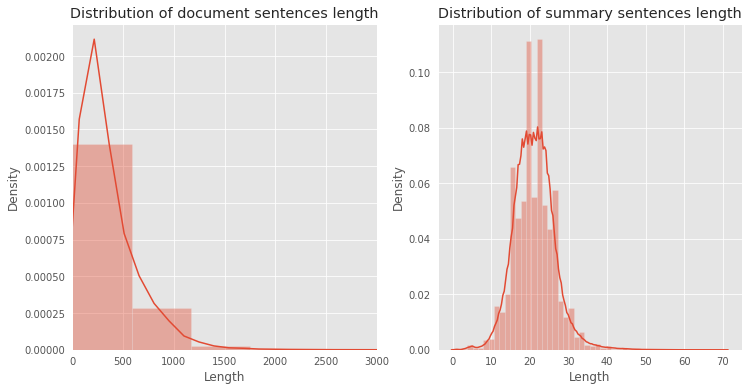

In [ ]:
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
sns.distplot(df_train['document'].str.split().apply(len))
plt.title('Distribution of document sentences length')
plt.xlabel('Length')
plt.xlim([0, 3000])

plt.style.use('ggplot')
plt.subplot(1, 2, 2)
sns.distplot(df_train['summary'].str.split().apply(len))
plt.title('Distribution of summary sentences length')
plt.xlabel('Length')
plt.show()

In [ ]:
tokenizer = T5TokenizerFast.from_pretrained('t5-base')

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

In [ ]:
class SummaryDataset(Dataset):
    
    def __init__(self, df, tokenizer, input_length = 512, output_length = 100):
        
        self.df = df
        self.tokenizer = tokenizer
        self.input_length = input_length
        self.output_length = output_length
    
    def __len__(self):
        
        return len(self.df)
    
    def __getitem__(self, index):
        data_row = self.df.iloc[index]
        document = data_row['document']
        summary = data_row['summary'
                          ]
        doc_encoding = self.tokenizer(
            document,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            max_length = self.input_length,
            return_tensors = 'pt'
        )
        summ_encoding = self.tokenizer(
            summary,
            padding = 'max_length',
            truncation = True,
            return_attention_mask = True,
            add_special_tokens = True,
            max_length = self.output_length,
            return_tensors = 'pt'
        )
        
        
        doc_encoding['input_ids'] = doc_encoding['input_ids'].flatten()
        doc_encoding['attention_mask'] = doc_encoding['attention_mask'].flatten()
        
        summ_encoding['input_ids'] = summ_encoding['input_ids'].flatten()
        summ_encoding['attention_mask'] = summ_encoding['attention_mask'].flatten()
        
        return {
            'doc_ids' : doc_encoding['input_ids'],
            'doc_mask' : doc_encoding['attention_mask'],
            'summ_ids' : summ_encoding['input_ids'],
            'summ_mask' : summ_encoding['attention_mask']
        }

In [ ]:
train_dataset = SummaryDataset(df_train, tokenizer, 512, 150)
test_dataset = SummaryDataset(df_test, tokenizer, 512, 150)
val_dataset = SummaryDataset(df_val, tokenizer, 512, 150)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 2, pin_memory = True, num_workers = 2, drop_last = True, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 2, pin_memory = True, num_workers = 2, drop_last = True, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 2, pin_memory = True, num_workers = 2, drop_last = True, shuffle = True)

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
for batch in train_loader:
    print(batch['doc_ids'].shape)
    print(batch['doc_mask'].shape)
    print(batch['summ_ids'].shape)
    print(batch['summ_mask'].shape)
    break

torch.Size([2, 512])
torch.Size([2, 512])
torch.Size([2, 150])
torch.Size([2, 150])


In [ ]:
EPOCHS = 1
learning_rate = 5e-5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [ ]:
!pip install Rouge
optimizer = AdamW(model.parameters(), lr = learning_rate, correct_bias = False)
from rouge import Rouge
rouge = Rouge()

In [ ]:
for batch in train_loader:
    y = batch['summ_ids']
    #print(y, y.shape)
    y_ids = y[:, :-1].contiguous()
    #print(y_ids, y_ids.shape)
    lm_labels = y[:, 1:].clone()
    #print(lm_labels, lm_labels.shape)
    lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
    ids = batch['doc_ids']
    mask = batch['doc_mask']
    mask.to(device)
    ids.to(device)
    y_ids.to(device)
    outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids)
    print(outputs[0].shape)
    break

RuntimeError: ignored

In [ ]:
def trainer(model, loader, optimizer, device):
    model = model.train()
    losses = []
    for batch in tqdm(loader):
        input_ids = batch['doc_ids'].to(device)
        input_mask = batch['doc_mask'].to(device)
        targets = batch['summ_ids'].to(device)
        target_mask = batch['summ_mask'].to(device)
        
        outputs = model(
            input_ids = input_ids,
            attention_mask = input_mask,
            labels = targets
        )
        
        loss = outputs.loss
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        
    return np.mean(losses)
        

In [ ]:
def evaluate(model, loader, device):
    model = model.eval()
    losses = []
    scores = []
    f_score = []
    precision = []
    recall = []
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['doc_ids'].to(device)
            input_mask = batch['doc_mask'].to(device)
            targets = batch['summ_ids'].to(device)
            target_mask = batch['summ_mask'].to(device)
            
            outputs = model(
                input_ids = input_ids,
                attention_mask = input_mask,
                labels = targets
            )
            
            out = model.generate(
                input_ids = input_ids,
                attention_mask = input_mask,
                do_sample = False
            )
            
            preds = tokenizer.batch_decode(
            out,
            skip_special_tokens = True
            )
            
            ground_truth = tokenizer.batch_decode(
            targets,
            skip_special_tokens = True,
            )
            
            score = rouge.get_scores(preds, ground_truth)
            
            scores.extend(score)
            
    for item in score:
        rouge_2 = item['rouge-2']
        f_score.append(rouge_2['f'])
        precision.append(rouge_2['p'])
        recall.append(rouge_2['r'])
            
    print(np.mean(np.array(f_score)), np.mean(np.array(precision)), np.mean(np.array(recall)))
    return  np.mean(np.array(f_score)), np.mean(np.array(precision)), np.mean(np.array(recall))

            
            

In [ ]:
from collections import defaultdict

In [ ]:
history = defaultdict(list)          
best_accuracy = 0                    
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_loss = trainer(
     model,
     train_loader,
     optimizer, 
     device
   )
    print(f'Train loss' ,train_loss)
    f_score, precision, recall = evaluate(
     model,
     val_loader, 
     device
   )

Epoch 1/1


100%|██████████| 102022/102022 [2:01:48<00:00, 13.96it/s]


Train loss 0.5363200390734979


100%|██████████| 5666/5666 [18:15<00:00,  5.17it/s]

0.06451612653485962 0.06666666666666667 0.0625


In [ ]:
torch.save(model.state_dict(), 'gdrive/My Drive/NLP/HW3/summary_model_t5.pth')

In [ ]:
f_score, precision, recall = evaluate(
    model,
    test_loader, 
    device
    )

  8%|▊         | 477/5667 [01:33<16:33,  5.22it/s]

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  review_texts = []
  losses = []
  scores = []
  f_score=[]
  precision = []
  recall = []
  real_values = []
  with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["text_input_ids"].to(device)
            input_attention_mask = d["text_attention_mask"].to(device)
            targets = d["labels"].to(device)
            summary_attention_mask = d['labels_attention_mask'].to(device)
            outputs = model(
               input_ids=input_ids,
               attention_mask=input_attention_mask,
               labels = targets
             )
            #temp_review_texts = d['text']
            #review_texts.extend(temp_review_texts)
            out = model.generate(input_ids = input_ids, attention_mask = input_attention_mask, do_sample= False)
            preds = tokenizer.batch_decode(out,skip_special_tokens = True)
            predictions.extend(preds)
            ground_truth = tokenizer.batch_decode(targets,skip_special_tokens = True)
            real_values.extend(ground_truth)
            score = rouge.get_scores(preds,ground_truth)
            #print(score)
            scores.extend(score)
  for item in score:
    rouge_2 = item['rouge-2']
    f_score.append(rouge_2['f'])
    precision.append(rouge_2['p'])
    recall.append(rouge_2['r'])
    
    
#       _, preds = torch.max(outputs, dim=1)
#       review_texts.extend(texts)
      
#       prediction_probs.extend(outputs)
#       real_values.extend(targets)
  #predictions = torch.stack(predictions).cpu()
  #review_texts = torch.stack(review_texts).cpu()
  #real_values = torch.stack(real_values).cpu()
#   prediction_probs = torch.stack(prediction_probs).cpu()
#   real_values = torch.stack(real_values).cpu()

  print(np.mean(np.array(f_score)), np.mean(np.array(precision)), np.mean(np.array(recall))) 
  return  predictions, real_values

In [ ]:
print(f'Train loss' ,train_loss)
    f_score, precision, recall = evaluate(
     model,
     val_loader, 
     device
   )